In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.graphics.regressionplots as sgr

In [2]:
data = pd.read_csv("results.csv", index_col=0)
data.columns

Index(['file_count', 'pi_count', 'time', 'timestamp'], dtype='object')

In [3]:
data.groupby('pi_count')['time'].describe()

,count,mean,std,min,25%,50%,75%,max
pi_count,,,,,,,,
1,3.0,768.969668,12.120681,761.601040,761.975124,762.349207,772.653983,782.958758
2,3.0,391.394798,12.521109,376.936672,387.774849,398.613025,398.623861,398.634696
3,3.0,324.482621,6.585242,317.476784,321.451113,325.425441,327.985540,330.545638
4,3.0,300.761213,6.606650,293.250232,298.305390,303.360547,304.516703,305.672859
5,3.0,159.577755,4.540377,154.572461,157.650913,160.729366,162.080402,163.431438


In [4]:
mod = smf.ols(formula='time ~ pi_count', data=data)
res = mod.fit()
res.summary()

/home/andrew/.local/lib/python3.6/site-packages/scipy/stats/stats.py:1390: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   time   R-squared:                       0.819
Model:                            OLS   Adj. R-squared:                  0.806
Method:                 Least Squares   F-statistic:                     58.99
Date:                Wed, 14 Mar 2018   Prob (F-statistic):           3.48e-06
Time:                        17:45:02   Log-Likelihood:                -88.260
No. Observations:                  15   AIC:                             180.5
Df Residuals:                      13   BIC:                             181.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    781.8624     56.542     13.828      0.000     659.711     904.014
pi_count    -130.9417     17.048     -7.681      0.000    -167.772     -94.112
==============================================================================
Omnibus:                        2.048   Durbin-Watson:                   0.837
Prob(Omnibus):                  0.359   Jarque-Bera (JB):                1.018
Skew:                          -0.196   Prob(JB):                        0.601
Kurtosis:                       1.786   Cond. No.                         8.37
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

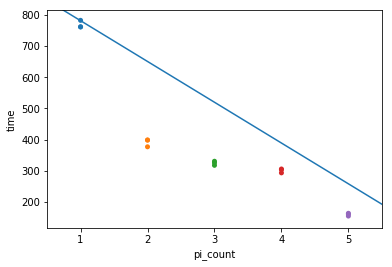

In [5]:
fig, ax = plt.subplots()
sns.stripplot(x='pi_count', y='time', data=data, ax=ax)
sgr.abline_plot(model_results=res, ax=ax)
fig.savefig("pi_count_v_time.png")

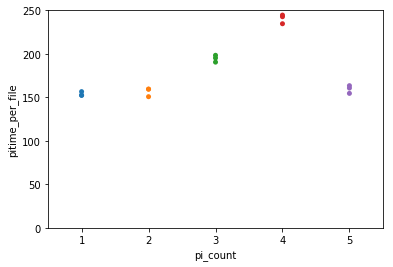

In [16]:
fig, ax = plt.subplots()
data['pitime_per_file'] = data['time']*data['pi_count']/data['file_count']
sns.stripplot(x='pi_count', y='pitime_per_file', data=data, ax=ax)
ax.set_ylim(bottom=0)
fig.savefig("pitime_per_file_vs_count.png")